<a href="https://colab.research.google.com/github/BeverlyHuang/amazon_review/blob/master/Amazon_Product_Review_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Amazon_Product_Review_Analysis

##Prepare data from url

In [0]:
import urllib.request

print('Beginning file download with urllib2...')

url = 'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Health_and_Personal_Care_5.json.gz'  
urllib.request.urlretrieve(url, 'reviews_Health_and_Personal_Care_5.json.gz')  

Beginning file download with urllib2...


('reviews_Health_and_Personal_Care_5.json.gz',
 <http.client.HTTPMessage at 0x7ff28098f978>)

In [0]:
import pandas as pd
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF("reviews_Health_and_Personal_Care_5.json.gz")


In [0]:
review = pd.DataFrame({'reviewerid':df['reviewerID'],'reviewText':df['reviewText'],'overall':df['overall']})

In [0]:
review.head()

,reviewerid,reviewText,overall
0,ALC5GH8CAMAI7,This is a great little gadget to have around. ...,5.0
1,AHKSURW85PJUE,I would recommend this for a travel magnifier ...,4.0
2,A38RMU1Y5TDP9,What I liked was the quality of the lens and t...,4.0
3,A1XZUG7DFXXOS4,Love the Great point light pocket magnifier! ...,4.0
4,A1MS3M7M7AM13X,This is very nice. You pull out on the magnifi...,5.0


##Transform with TF-IDF

###Pre-processing data - retain meaningful words

In [0]:
import gensim
import nltk.stem as stemmer

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
def prep(review):   # returns a string in which the elements of sequence have been joined by str separator
    review = review.lower()    
    return "".join(review)

def lemmatize_stemming(text):
    return WordNetLemmatizer().lemmatize(text, pos='v')

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text): # convert a document into a list of tokens
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3: # remove stopwords and words appearing less than 3 times
            result.append(lemmatize_stemming(token))
    return " ".join(result)


In [0]:
#checking
doc_sample = '''product's liked eating candies'''  #review[review['reviewerid'] == 'ALC5GH8CAMAI7'].values[0][1]
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
["product's", 'liked', 'eating', 'candies']


 tokenized and lemmatized document: 
product like eat candy


In [0]:
review['reviewText'] = review['reviewText'].map(prep)
review['reviewText'] = review['reviewText'].map(preprocess)
review['reviewText'][:10]

0    great little gadget look splinter use light gr...
1    recommend travel magnifier occasional read rea...
2    like quality lens build light lens discernable...
3    love great point light pocket magnifier work g...
4    nice pull magnifier want light come slide reco...
5    light come item pull easier plastic bookmark m...
6    lightweight efficient good point batteries mon...
7    buy road trip try interpret map have strain ey...
8    screen magnifier small look read text go work ...
9    pocket magnifier nice compact slide feature ma...
Name: reviewText, dtype: object

In [0]:
review['overall'] = review['overall'].apply(lambda x: 1 if (x>=4) else 0)
review.set_index('reviewerid', inplace = True)
review.head()

,reviewText,overall
reviewerid,,
ALC5GH8CAMAI7,great little gadget look splinter use light gr...,1
AHKSURW85PJUE,recommend travel magnifier occasional read rea...,1
A38RMU1Y5TDP9,like quality lens build light lens discernable...,1
A1XZUG7DFXXOS4,love great point light pocket magnifier work g...,1
A1MS3M7M7AM13X,nice pull magnifier want light come slide reco...,1


###Split train-test set

In [0]:
from sklearn.model_selection import train_test_split

target='overall' #EXPECTED OUTPUT

x_columns = [x for x in review.columns if x not in [target]]

X = review[x_columns]
y = review['overall']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state=1)

print('Training dim:', X_train.shape, 'Test dim:', X_test.shape)

Training dim: (277084, 1) Test dim: (69271, 1)


###Implement TF-IDF

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import words

tv = TfidfVectorizer(
                    ngram_range = (1,3),
                    sublinear_tf = True,
                    max_features = 3000) # Convert a collection of raw documents to a matrix of TF-IDF features

In [0]:
train_tv = tv.fit_transform(X_train['reviewText'])
test_tv = tv.transform(X_test['reviewText'])

In [0]:
import numpy as np
vocab = tv.get_feature_names()
dist = np.sum(train_tv, axis=0)
checking = pd.DataFrame(dist, columns = vocab)
checking

,ability,able,absolute,absolutely,absolutely love,absorb,absorbent,absorption,acceptable,access,accident,accidentally,accord,account,accuracy,accurate,acetaminophen,ache,ache pain,achieve,acid,acids,acne,act,action,activate,active,active ingredient,activities,activity,actual,actually,actually work,adapter,add,addition,additional,additionally,additives,address,...,work think,work time,work try,work wonder,work work,workout,workouts,world,worry,worse,worst,worth,worth money,worth price,wouldn,wrap,wrinkle,wrist,wrists,write,write review,wrong,xylitol,yard,yeah,year,years,years try,years work,yeast,yellow,yesterday,yogurt,young,younger,yummy,zero,zinc,zippo,zone
0,296.616661,1430.221567,122.509372,736.843024,206.827801,573.824918,271.365733,206.866996,110.162797,128.861398,138.968493,142.732264,275.959646,97.25334,151.714962,783.109418,92.358614,435.918322,154.233531,149.135065,597.163031,184.243363,201.595561,175.598896,238.943019,90.358459,429.913612,128.725311,113.262164,174.157284,329.677132,1798.835558,272.480223,91.079132,1116.548661,525.645398,320.316547,98.452485,140.748597,118.133271,...,125.568123,215.801529,146.54665,211.995605,298.979651,774.447376,358.340697,310.559513,779.047883,504.84227,278.892166,1776.580414,303.323543,247.595997,842.721215,629.601232,141.424905,410.880145,113.799078,564.978718,193.970094,732.232341,98.090711,122.847453,180.054264,1613.005338,3123.027258,124.439768,169.398604,242.433305,245.629414,140.716998,191.273042,215.366913,142.134032,177.700967,232.230864,224.055294,147.306699,87.692079


In [0]:
print('Training dim:',train_tv.shape, 'Test dim:', test_tv.shape)

Training dim: (277084, 3000) Test dim: (69271, 3000)


##Classificaion Model building & Model evaluation
 Build the model with default parameters, as well as with grid search
 
 Evaluate with confusion matrix, ROC-AUC, precision, recall, F-1

In [0]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

from yellowbrick.classifier import ROCAUC
import sklearn.model_selection

from yellowbrick.classifier import ConfusionMatrix


###Logistic Regression

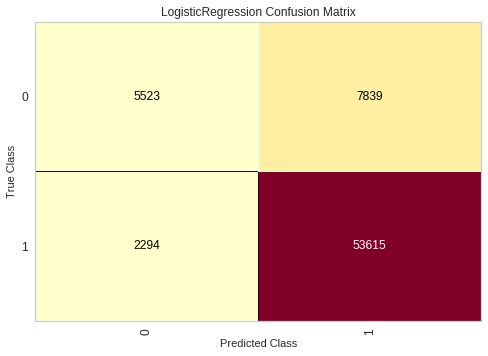

0.8537194496975646

In [0]:
model = LogisticRegression()

cm = ConfusionMatrix(model, classes=[0,1])
cm.fit(train_tv, y_train)
y_predlg = model.predict(test_tv)

cm.score(test_tv, y_test)
cm.poof()
model.score(test_tv, y_test)

####GridSearch

In [0]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
gsearchLR = GridSearchCV(LogisticRegression(), param_grid)
gsearchLR.fit(train_tv,y_train)
gsearchLR.best_params_, gsearchLR.best_score_

({'C': 1}, 0.8539107274328362)

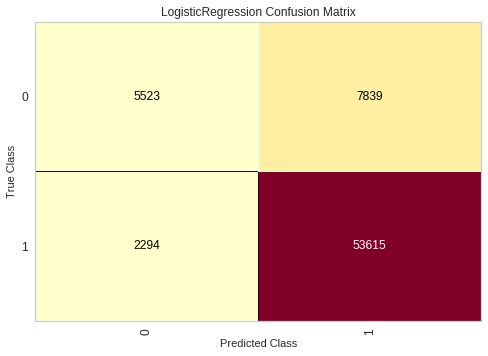

0.8537194496975646

In [0]:
model_lg = LogisticRegression(C = 1)

cm = ConfusionMatrix(model_lg, classes=[0,1])
cm.fit(train_tv, y_train)
y_predlg = model_lg.predict(test_tv)

cm.score(test_tv, y_test)
cm.poof()
model_lg.score(test_tv, y_test)

In [0]:
print("Classification report for classifier %s:\n%s\n"
      % (model_lg, metrics.classification_report(y_test, y_predlg)))

Classification report for classifier LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.71      0.41      0.52     13362
           1       0.87      0.96      0.91     55909

   micro avg       0.85      0.85      0.85     69271
   macro avg       0.79      0.69      0.72     69271
weighted avg       0.84      0.85      0.84     69271




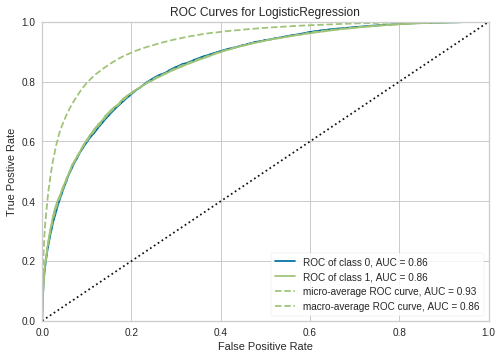

In [0]:
classes=[0,1]
visualizer = ROCAUC(model_lg, classes=classes)

visualizer.fit(train_tv, y_train)  
visualizer.score(test_tv, y_test)  
g = visualizer.poof()             

###SVM

####Initial Model

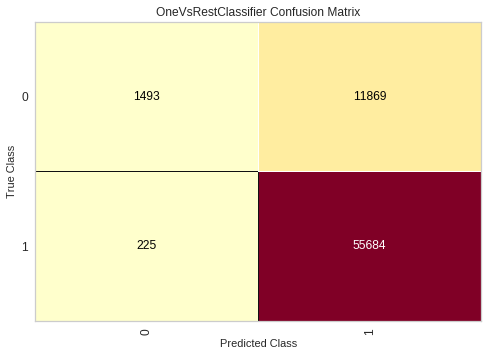

0.8254103448773658

In [0]:
from sklearn.ensemble import BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
n_estimators = 10

model2 = OneVsRestClassifier(BaggingClassifier(SVC(kernel='linear', probability=True),  max_samples= 0.01,n_estimators=n_estimators))
cm = ConfusionMatrix(model2, classes=[0,1])
cm.fit(train_tv, y_train)
y_predsvm = model2.predict(test_tv)

cm.score(test_tv, y_test)
cm.poof()
model2.score(test_tv, y_test)


####GridSearch

In [0]:
estimatnum = [1,5, 10]
param_grid = {'n_estimators': estimatnum}

gsearchSVM = GridSearchCV(BaggingClassifier(SVC(kernel='linear', probability=True),  max_samples= 0.01),                              
                        param_grid = param_test1,scoring='roc_auc',cv=2)


gsearchSVM.fit(train_tv,y_train)
gsearchSVM.best_params_, gsearchLR.best_score_

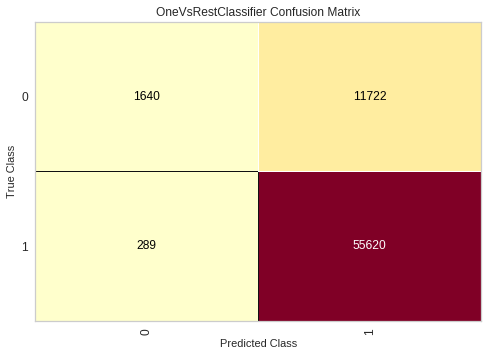

0.826608537483218

In [0]:
model_svm =  OneVsRestClassifier(BaggingClassifier(SVC(kernel='linear', probability=True),  max_samples= 0.01,n_estimators=5))


cm = ConfusionMatrix(model_svm, classes=[0,1])
cm.fit(train_tv, y_train)
y_predsvm = model_svm.predict(test_tv)


cm.score(test_tv, y_test)
cm.poof()
model_svm.score(test_tv, y_test)

In [0]:
print("Classification report for classifier %s:\n%s\n"
      % (model_svm, metrics.classification_report(y_test, y_predsvm)))

Classification report for classifier OneVsRestClassifier(estimator=BaggingClassifier(base_estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.01, n_estimators=5, n_jobs=None, oob_score=False,
         random_state=None, verbose=0, warm_start=False),
          n_jobs=None):
              precision    recall  f1-score   support

           0       0.85      0.12      0.21     13362
           1       0.83      0.99      0.90     55909

   micro avg       0.83      0.83      0.83     69271
   macro avg       0.84      0.56      0.56     69271
weighted avg       0.83      0.83      0.77     69271




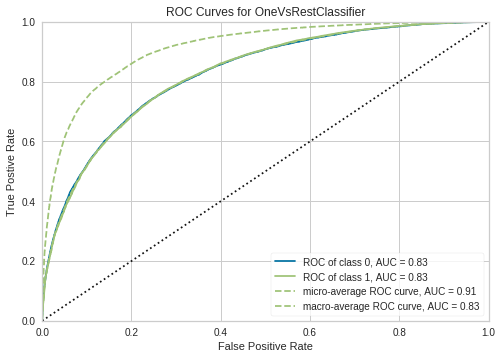

In [0]:
classes=[0,1]

# Instantiate the visualizer with the SVC classification model
visualizer = ROCAUC(model_svm, classes=classes)

visualizer.fit(train_tv, y_train)  # Fit the training data to the visualizer
visualizer.score(test_tv, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

###Random Forest

####Initial Model

In [0]:
rf1 = OneVsRestClassifier(BaggingClassifier(RandomForestClassifier(n_estimators= 100, #max_depth=6, min_samples_split=2,
                                  random_state=10),  max_samples= 0.01,n_estimators=10))

modelrf = rf1.fit(train_tv,y_train)

y_predrf = rf1.predict_proba(test_tv)[:,1]
print("ROC_AUC Score (Train): %f" % metrics.roc_auc_score(y_test, y_predrf))

ROC_AUC Score (Train): 0.801729


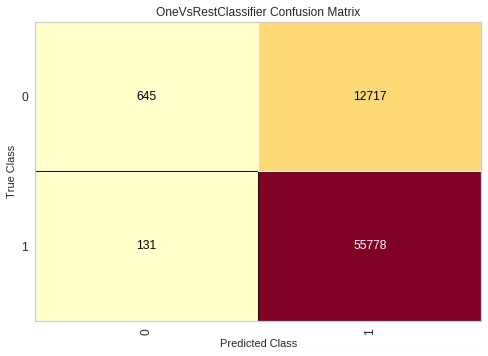

0.8145255590362489

In [0]:
cm = ConfusionMatrix(rf1, classes=[0,1])
cm.fit(train_tv,y_train)
cm.score(test_tv, y_test)
cm.poof()
rf1.score(test_tv, y_test)

####GridSearch

In [0]:
param_test1 = {'n_estimators':list(range(90,110,10))}  
gsearch1 = GridSearchCV(estimator = RandomForestClassifier(oob_score=True,  random_state=10),                              
                       param_grid = param_test1, scoring='roc_auc',cv=2)

gsearch1.fit(train_tv,y_train)
gsearch1.best_params_, gsearch1.best_score_

In [0]:
rf0 = RandomForestClassifier(n_estimators= 100, oob_score=True, random_state=10)
rf0.fit(train_tv,y_train)
print(rf0.oob_score_)
y_predrf = rf0.predict_proba(test_tv)[:,1]
print("ROC_AUC Score (Train): %f" % metrics.roc_auc_score(y_test, y_predrf))

0.8357212975126677
ROC_AUC Score (Train): 0.832941


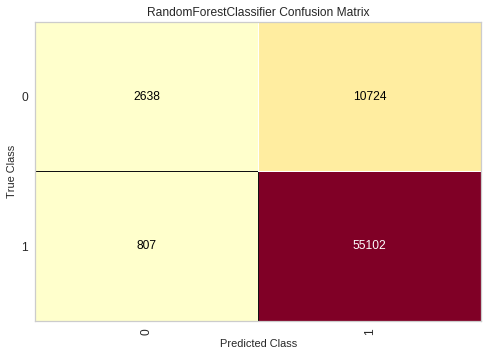

0.8335378441194728

In [0]:
cm = ConfusionMatrix(rf0, classes=[0,1])
cm.fit(train_tv, y_train)
cm.score(test_tv, y_test)
cm.poof()
rf0.score(test_tv, y_test)

In [0]:
y_predrf = rf0.predict(test_tv)
print("Classification report for classifier %s:\n%s\n"
      % (rf0, metrics.classification_report(y_test, y_predrf)))

Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=True, random_state=10, verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.77      0.20      0.31     13362
           1       0.84      0.99      0.91     55909

   micro avg       0.83      0.83      0.83     69271
   macro avg       0.80      0.59      0.61     69271
weighted avg       0.82      0.83      0.79     69271




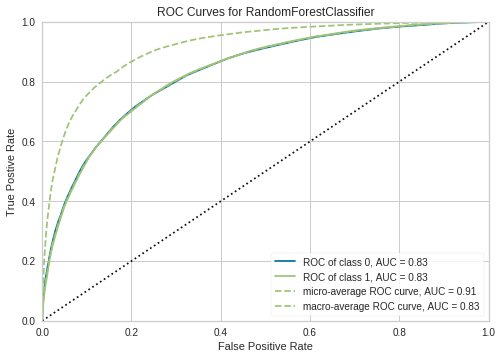

In [0]:
#rf0 = RandomForestClassifier(n_estimators= 100, oob_score=True, random_state=10)

classes=[0,1]
visualizer = ROCAUC(rf0, classes=classes)

visualizer.fit(train_tv, y_train)  
visualizer.score(test_tv, y_test)  
g = visualizer.poof() 

##LDA Model - Extract the hidden topics

In [0]:
# Build LDA Model
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD

lda_model = LatentDirichletAllocation(n_topics=10,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',  # Online variational Bayes method. In each EM update, use mini-batch of training data to update the ``components_``variable incrementally. 
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(test_tv)

print(lda_model)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=10, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


LDA Evaluation

In [0]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(test_tv)) # Calculate approximate log-likelihood as score

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(test_tv)) # Perplexity is the measure of how well a model predicts a sample

Log Likelihood:  -2601325.921293391
Perplexity:  4178.411076274591


In [0]:
# Create Document - Topic Matrix
lda_output = lda_model.transform(test_tv)

# column names
topicnames = ["Topic" + str(i) for i in range(lda_model.n_topics)]

# index names
docnames = ["review" + str(i) for i in range(test_tv.shape[0])]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each review
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(10).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
review0,0.1,0.02,0.02,0.02,0.02,0.71,0.02,0.02,0.02,0.02,5
review1,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.78,9
review2,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.5,0.18,0.16,7
review3,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.43,0.02,0.4,7
review4,0.57,0.25,0.02,0.02,0.06,0.02,0.02,0.02,0.02,0.02,0
review5,0.41,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.42,9
review6,0.02,0.02,0.02,0.02,0.02,0.83,0.02,0.02,0.02,0.02,5
review7,0.02,0.02,0.02,0.02,0.02,0.41,0.02,0.02,0.02,0.46,9
review8,0.02,0.02,0.02,0.76,0.02,0.02,0.02,0.02,0.02,0.1,3
review9,0.02,0.44,0.02,0.02,0.02,0.4,0.02,0.02,0.05,0.02,1


Topic Distribution

In [0]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,5,33046
1,9,15334
2,1,8550
3,7,5188
4,2,2866
5,0,2838
6,3,1054
7,6,260
8,8,74
9,4,61


See topics' keywords

In [0]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda_model.components_)
topicnames = ["Topic" + str(i) for i in range(lda_model.n_topics)]


# Assign Column and Index
df_topic_keywords.columns = vocab
df_topic_keywords.index = topicnames

# View
df_topic_keywords

,ability,able,absolute,absolutely,absolutely love,absorb,absorbent,absorption,acceptable,access,accident,accidentally,accord,account,accuracy,accurate,acetaminophen,ache,ache pain,achieve,acid,acids,acne,act,action,activate,active,active ingredient,activities,activity,actual,actually,actually work,adapter,add,addition,additional,additionally,additives,address,...,work think,work time,work try,work wonder,work work,workout,workouts,world,worry,worse,worst,worth,worth money,worth price,wouldn,wrap,wrinkle,wrist,wrists,write,write review,wrong,xylitol,yard,yeah,year,years,years try,years work,yeast,yellow,yesterday,yogurt,young,younger,yummy,zero,zinc,zippo,zone
Topic0,0.100021,20.600673,0.100097,0.100034,0.100048,0.100040,12.360982,0.100165,0.100018,0.100027,11.921743,0.100148,0.100077,0.100019,0.100001,0.100007,0.100058,97.685156,41.132823,0.100079,0.100076,0.100003,0.100075,34.571430,0.100123,0.100016,0.100206,0.100018,15.086393,0.100042,0.100022,0.100048,0.100030,0.100003,0.100034,3.263626,7.478049,0.100017,0.100026,0.100027,...,0.100021,0.100060,0.100155,37.639039,0.100029,0.100024,0.100025,0.100028,0.100017,23.397737,25.295287,11.319036,0.100045,0.100111,0.100048,0.100057,0.100056,17.068248,14.597180,0.100013,0.100012,0.100021,0.100038,0.100022,0.100012,0.100057,63.072174,0.100027,21.883530,26.065577,0.100015,0.100295,0.100006,0.100142,0.100060,0.100007,0.100045,0.100031,0.100025,0.100063
Topic1,6.669268,19.134094,0.100630,16.699388,0.100032,0.100019,0.100066,0.100037,0.100084,0.100135,0.100021,28.455409,6.522579,0.100015,0.100003,0.100006,0.100005,0.100023,0.100001,0.100064,0.100040,0.100001,0.100298,0.100166,47.087159,0.100048,0.100191,0.100007,0.100014,0.100007,0.100049,53.102152,0.100036,0.100042,12.174998,0.100175,25.271907,0.100030,0.100009,0.100030,...,0.100038,0.100048,34.126487,0.100023,0.100038,0.100006,0.100012,0.100076,12.653226,7.245566,0.100631,74.615408,0.100156,24.632985,20.911897,0.100033,5.958586,0.100004,0.100003,0.100025,0.100026,21.476013,0.100026,0.100006,0.100039,62.388485,157.124668,0.100043,0.100052,0.100001,7.932612,12.672097,0.100005,0.100516,15.580551,0.100020,0.100032,0.100002,30.774632,0.100554
Topic2,0.100017,0.100018,8.472620,0.100065,0.100094,2.994989,46.383589,0.100038,0.100053,0.100075,0.100017,0.100111,0.100064,0.100001,0.100000,0.100057,0.100001,0.100004,0.100001,0.100045,0.100022,0.100011,0.100013,4.443377,0.100027,0.100028,0.100194,0.100042,0.100078,0.100025,0.100039,14.841916,0.100017,0.100001,47.041960,9.049316,0.100098,0.100026,0.100038,0.100008,...,0.100020,0.100020,0.100062,0.100006,0.100018,32.721816,0.100070,0.100034,0.100181,0.100026,0.100069,0.100054,0.100009,0.100061,5.588426,0.100018,0.100012,0.100002,0.100009,0.100012,0.100029,8.708162,0.100126,0.100012,0.100029,0.100039,2.087801,0.100022,0.100017,0.100017,0.100013,0.100095,0.100224,0.100067,0.100032,38.807159,0.100078,0.100006,0.100002,0.100077
Topic3,0.100034,0.100048,0.100027,8.877854,0.100053,0.100017,0.100005,0.100024,0.100041,0.100023,0.100003,0.100028,0.100036,0.100345,0.100004,0.100033,0.100001,0.100007,0.100001,0.100337,0.100008,0.100004,0.100003,0.100018,0.100029,0.100011,0.100078,0.100008,0.100073,0.100075,0.100022,8.100196,2.948367,0.100000,0.100030,0.100023,0.100036,0.100010,0.100008,0.100002,...,0.100418,51.894238,0.100428,3.986346,0.100070,38.247206,53.099143,0.100019,0.100026,0.100014,0.100018,41.674208,62.380060,0.100024,0.100061,0.100018,0.100035,0.100003,0.100004,0.100021,0.100034,0.100029,0.100012,0.100021,0.100081,0.100025,0.100020,0.100003,0.100026,0.100012,0.100004,0.100268,0.100070,0.100011,0.100074,0.100006,0.100074,0.100002,0.100000,0.100024
Topic4,0.100015,0.100015,0.100236,0.100015,0.100010,0.100009,0.100039,0.100045,32.456013,0.100081,0.100017,0.100062,0.100036,0.100082,0.100022,0.100024,0.100011,0.100006,0.100001,0.100032,0.100009,0.100002,0.100003,0.100092,0.100037,0.100013,0.100123,0.100020,5.218244,1.835450,0.100013,0.100019,0.100013,0.100009,0.100013,0.100019,0.100076,0.100011,0.100004,0.10

In [0]:
df_topic = df_topic_keywords.transpose()

In [0]:
df_topic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3000 entries, ability to zone
Data columns (total 10 columns):
Topic0    3000 non-null float64
Topic1    3000 non-null float64
Topic2    3000 non-null float64
Topic3    3000 non-null float64
Topic4    3000 non-null float64
Topic5    3000 non-null float64
Topic6    3000 non-null float64
Topic7    3000 non-null float64
Topic8    3000 non-null float64
Topic9    3000 non-null float64
dtypes: float64(10)
memory usage: 337.8+ KB


In [0]:
df_topic.sort_values('Topic5',ascending = False).head(10) 

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9
work,181.159619,199.005822,21.938492,83.442807,0.100018,1032.368011,103.830646,205.744583,1.695035,359.517687
like,60.308547,268.177358,225.659166,6.631139,0.100017,864.321972,3.739617,229.494505,0.100018,276.581420
great,105.927594,255.755526,205.311546,46.908939,0.100025,794.197481,34.706414,73.870646,6.656202,327.492316
time,57.894790,170.580317,17.842774,54.661380,0.100016,766.957209,0.100021,119.901607,0.100017,223.208370
product,138.230776,111.792489,26.707536,80.913273,0.100016,748.257160,7.150199,95.930229,0.100019,868.219736
good,35.566626,219.280036,166.995527,8.926843,0.100019,742.733617,20.507357,144.720387,0.100022,509.432629
price,5.904884,99.914768,33.223063,0.100025,0.100018,703.912808,17.171621,0.100037,13.750595,317.302308
need,39.350661,97.204136,12.750409,7.683498,0.100021,702.271323,3.026580,99.538325,0.100023,254.804712
clean,5.961718,370.114463,0.100066,0.100034,0.100009,656.092017,0.753348,0.100028,0.100018,19.446631
buy,56.047618,119.505585,23.249740,7.212391,0.100017,602.843197,2.282450,32.838080,5.133709,162.234322


In [0]:
df_topic.sort_values('Topic9',ascending = False).head(10) 

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9
product,138.230776,111.792489,26.707536,80.913273,0.100016,748.257160,7.150199,95.930229,0.100019,868.219736
supplement,2.346182,0.100007,5.537235,0.100078,0.100007,0.100023,0.100006,89.083610,0.100014,587.826517
take,26.590249,50.151392,0.100019,61.859306,0.100020,191.417409,0.100017,317.992922,0.100012,565.471350
good,35.566626,219.280036,166.995527,8.926843,0.100019,742.733617,20.507357,144.720387,0.100022,509.432629
recommend,64.826829,141.523230,26.263860,27.127655,0.100018,408.773867,0.109371,66.277859,0.100019,442.654143
help,265.022380,25.283697,0.100035,73.360660,0.100064,207.443945,0.100067,208.674124,0.100013,387.113487
work,181.159619,199.005822,21.938492,83.442807,0.100018,1032.368011,103.830646,205.744583,1.695035,359.517687
vitamin,0.100030,0.100015,0.100015,0.100006,0.100008,0.100032,0.100004,73.885057,0.100008,334.104014
great,105.927594,255.755526,205.311546,46.908939,0.100025,794.197481,34.706414,73.870646,6.656202,327.492316
price,5.904884,99.914768,33.223063,0.100025,0.100018,703.912808,17.171621,0.100037,13.750595,317.302308


##Conclusion

* Preprocessing data 
 * We only keep the reviewtext column to do the sentiment analysis
 * Since the rating ranges from 1 to 5, to build the binary model, we consider rating higher or equals to 4 indicates the customer is satisfied, otherwise we consider the customer is not satisfied.
 * Remain meaningful words with Lemmatizer. By keeping only meaningful words, you can making following model building process more efficient
 * TF-IDF help to easy convert text to vector and calculate each keywords' weights within a matrix

* Classification model buidling 
 * Three Machine Learning Models are used for prediction
 * Grid search is applied to increase the models performance
 * Three models are evaluated on precision, recall, F-1 score and ROC-AUC
 * In this problem, we want to minimize false positives (misclassification of a dissatisfied customer into satisfied), which is to maximize the precision of our prediction
 * Overall logistic regression performs best with the highest accuracy and precision

* LDA model interpretation
 * By implementing LDA model, you can easily extract the top topics in those reviews
 * By looking at key words of each topics, you can quickly understand customers' overall feedback on products and understand the market trend